In [1]:
from envs.grid_3_actions import Grid
from policy import ForwardPolicy, BackwardPolicy

from gflownet.gflownet import GFlowNet
from gflownet.utils import trajectory_balance_loss

from torch.optim import Adam
from torch.nn.functional import one_hot
import torch

1. Initialize the grid environment using a grid size
2. Define a policy network taking a state vector as input and outputting a vector of probabilities over possible actions. (In the grid domain, the number of actions is three: **Down**, **Right**, and **Terminate**.)
3. Define a backward policy. In this case, the policy is not estimated but fixed to 0.5 for all parent states (except when there is only one parent state).

In [2]:
grid_size = 16
hidden_dim = 32

In [3]:
env = Grid(size=grid_size)
num_actions = env.num_actions
backward_policy = BackwardPolicy(env.state_dim, num_actions=num_actions)
forward_policy = ForwardPolicy(env.state_dim, hidden_dim=hidden_dim, num_actions=num_actions)
model = GFlowNet(forward_policy, backward_policy, env)
opt = Adam(model.parameters(), lr=5e-3)


To train the model, construct an NxD matrix of initial states, where N is the desired number of samples and D is the dimensionality of the state vector (i.e. `state_dim`). Then, draw samples from the model using the `sample_states` method, giving it the initial states and setting `return_log=True`. The resulting `Log` object contains information about the trajectory of each sample, which is used to compute the trajectory balance loss.

In [4]:
num_epochs = 1500
batch_size = 32

In [5]:
for i in range(num_epochs):
  s0 = one_hot(torch.zeros(batch_size).long(), env.state_dim).float()
  s, log = model.sample_states(s0, return_log=True)
  
  loss = trajectory_balance_loss(log.total_flow, log.rewards, log.fwd_probs, log.back_probs)
  loss.backward()
  opt.step()
  opt.zero_grad()
  
  print(f"Epoch {i}: {loss.item()}", end="\r")

Finally, when the model has been trained, you can sample states using the same `sample_states(...)` method as before, this time without needing to supply the `return_log=True` argument.

In [6]:
test_size = 10**4

In [7]:

with torch.no_grad() : 
    s0 = one_hot(torch.zeros(test_size).long(), env.state_dim).float()
    s = model.sample_states(s0)

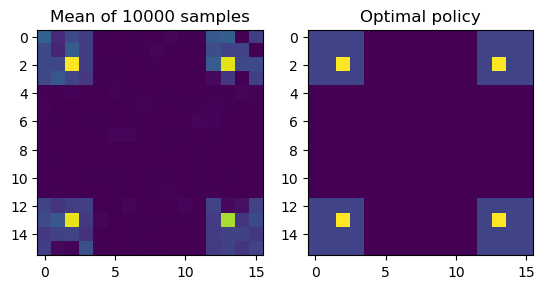

In [8]:
import matplotlib.pyplot as plt
figure = plt.figure()
s_2d = s.reshape(-1,  grid_size, grid_size)
s_2d = s_2d.mean(dim=0).reshape(grid_size, grid_size).numpy()

f1 = figure.add_subplot(1, 2, 1)
f1.set_title('Mean of ' + str(test_size) + ' samples')
plt.imshow(s_2d)

f2 = figure.add_subplot(1, 2, 2)
f2.set_title('Optimal policy')
plt.imshow(env.to_grid().reshape(grid_size, grid_size).numpy())


In [9]:
#save image to file
figure.savefig('test_g' + str(grid_size) + '_h' + str(hidden_dim) + '_a' + str(num_actions) + '_e' + str(num_epochs) + '.png')